The first mission that we collected data for was the Artemis mission, which orbits the moon. For this mission we had to obtain 3 data sets, the one for Artemis solar wind and its coordinates in relation to the Earth and to the Moon, one for Artmemis position in relation to the Sun, and the OMNI dataset.

After filtering out values that were invalid (the OMNI site uses 1E-32 instead of leaving the values blank), we saw a number of periods where there were dips in the solar wind speed and density. Since there were dips in both values, we determined that they were probably caused by the position of the probe along the Earth and Moon's ecliptic planes (i.e. the probe passing behind the Earth or the Moon and being blocked from the Sun).

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle("Artemis velocity and position data")

df = pd.read_csv('csv files/ArtemisMerged2.csv')
df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])

df.rename(columns = {'IonDensityN_cc':'ArtemisIonDensityN_CC',
                     'VTH_ION_FULL_ESA-B__km/s':'ArtemisIonSpeedKM_S',
                     'RAD_AU_AU':'ArtemisDistanceAU',
                     'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ':'Time',
                     'X_(@_x_)_Re':'GSEXCoordinate_Re',
                     'X_(@_x_)_Rm':'SSEXCoordinate_Rm'}, inplace = True)

fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Artemis speed")
ax = plt.gca()
df.plot(kind='line', x='Time', y='ArtemisIonSpeedKM_S', color='red', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Artemis density")
ay = plt.gca()
df.plot(kind='line', x='Time', y='ArtemisIonDensityN_CC', color='red', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Artemis X position in relation to the Earth")
az = plt.gca()
df.plot(kind='line', x='Time', y='GSEXCoordinate_Re', color='red', ax=az)
plt.ylabel("GSE X Coordinates")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Artemis X position in relation to the Moon")
az = plt.gca()
df.plot(kind='line', x='Time', y='SSEXCoordinate_Rm', color='red', ax=az)
plt.ylabel("SSE X Coordinates")


Text(0, 0.5, 'SSE X Coordinates')

After filtering out these periods where Artemis is blocked by the Earth or the Moon, and resampling on an hourly timescale we are left with much more consistent data that matches up with the OMNI data much better. For the time-shift on this mission we essentially subtracted an hour from the Artemis time and then joined the two datasets together based upon that new time. All plots are based off of the time from the Artemis dataset.

Text(0, 0.5, 'AU')

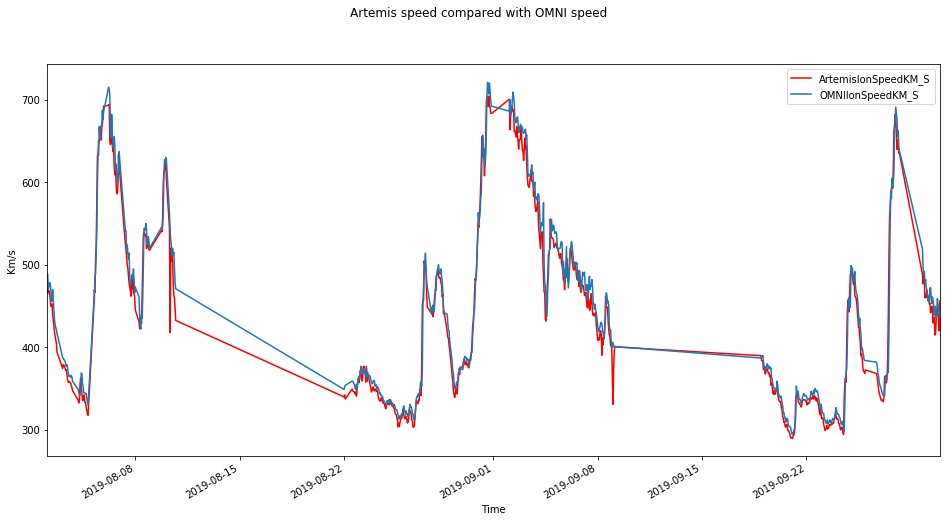

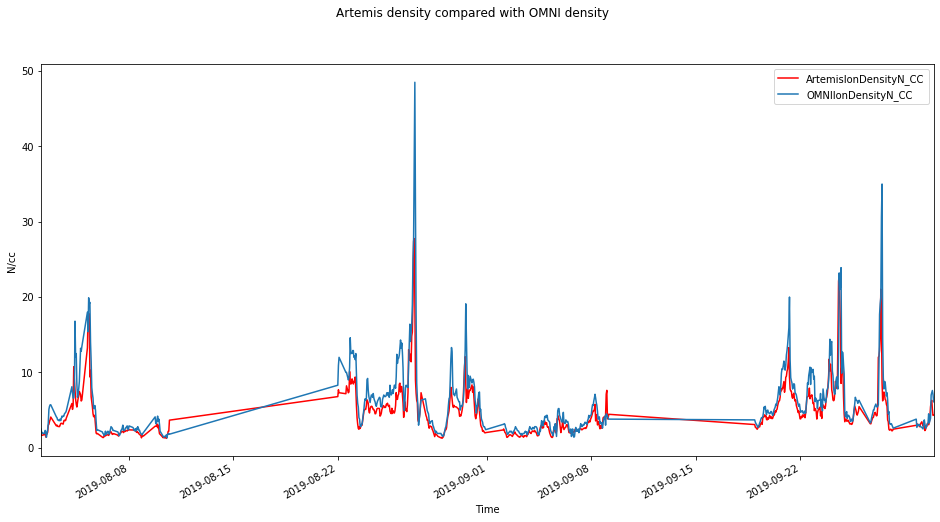

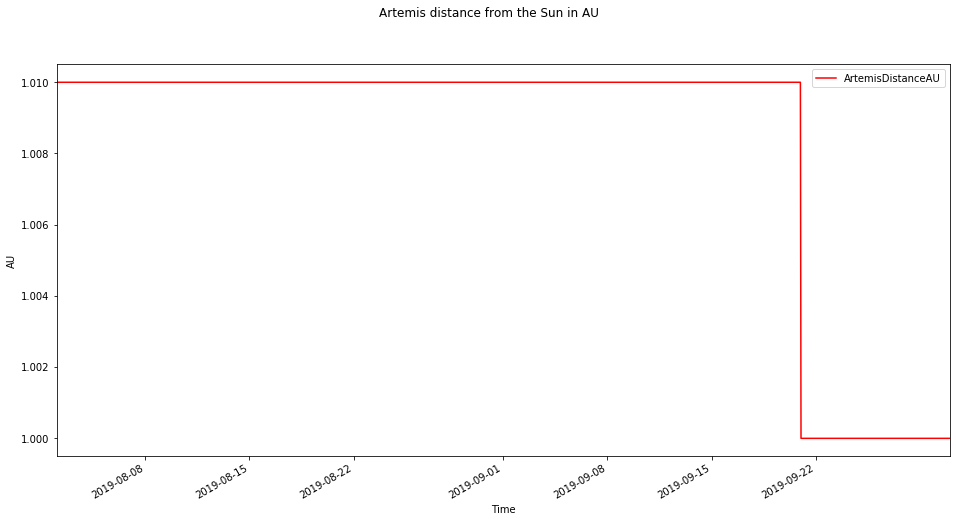

In [2]:
df = df[df['GSEXCoordinate_Re'] >= -35]
df = df[df['SSEXCoordinate_Rm'] >= 0]
df = df.resample('H', on = 'Time').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis2.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['ION_DENSITY_N/cm3'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

#df = df.drop(['X_(@_x_)_Re', 'Y_(@_y_)_Re', 'Z_(@_z_)_Re', 'X_(@_x_)_Rm', 'Y_(@_y_)_Rm', 'Z_(@_z_)_Rm','Unnamed: 0'], axis=1)
df['new_time'] = df['Time'] - pd.Timedelta(hours = 1)
df['Time_offset_hours'] = 1

mF = pd.merge(df2, df, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#mF.rename(columns = {'IonDensityN_cc':'ArtemisIonDensityN_CC',
#                     'VTH_ION_FULL_ESA-B__km/s':'ArtemisIonSpeedKM_S',
#                     'RAD_AU_AU':'ArtemisDistanceAU',
#                     'HGI_LAT_deg':'ArtemisLatDeg',
#                     'HGI_LON_deg':'ArtemisLonDeg'}, inplace = True)

mF.rename(columns = {'HELIOGRAPHIC_LATITUDE_deg':'OMNILatDeg',
                     'HELIOGRAPHIC_LONGITUDE_deg':'OMNILonDeg',
                     'BULK_FLOW_SPEED_km/s':'OMNIIonSpeedKM_S',
                     'ION_DENSITY_N/cm3':'OMNIIonDensityN_CC',
                     'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ':'OMNI Time'}, inplace = True)

fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='Time', y='ArtemisIonSpeedKM_S', color='red', ax=ax)
mF.plot(kind='line', x='Time', y='OMNIIonSpeedKM_S', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='Time', y='ArtemisIonDensityN_CC', color='red', ax=ay)
mF.plot(kind='line', x='Time', y='OMNIIonDensityN_CC', ax=ay)
plt.ylabel("N/cc")


fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='Time', y='ArtemisDistanceAU', color='red', ax=az)
plt.ylabel("AU")

Later on we needed to collect more data, as well as add a couple more columns. For this data we collected appoximately 7 month's worth of data, and added columns for magnetic field average, latitude difference, and longitude difference. In addition, we scaled the density by the distance squared and the magnetic field average by distance in order to make the data from Artemis match even more closely with the OMNI dataset.

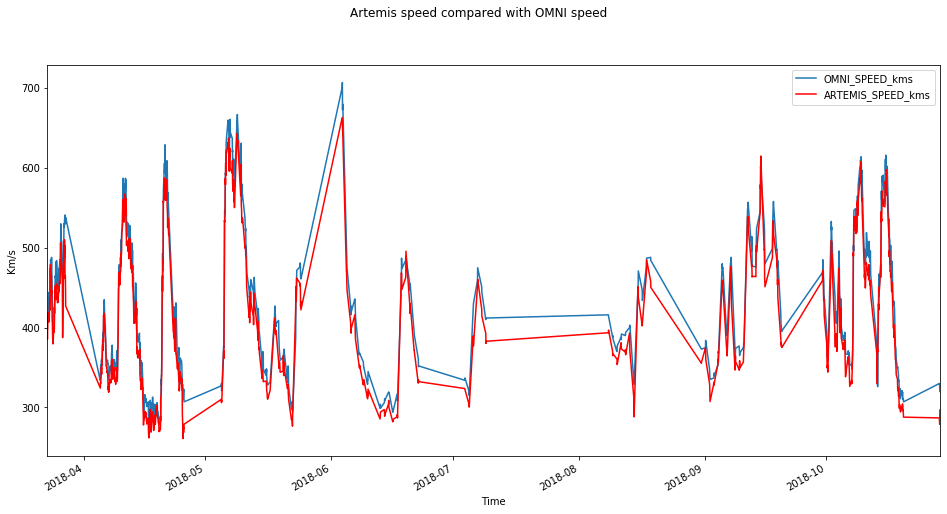

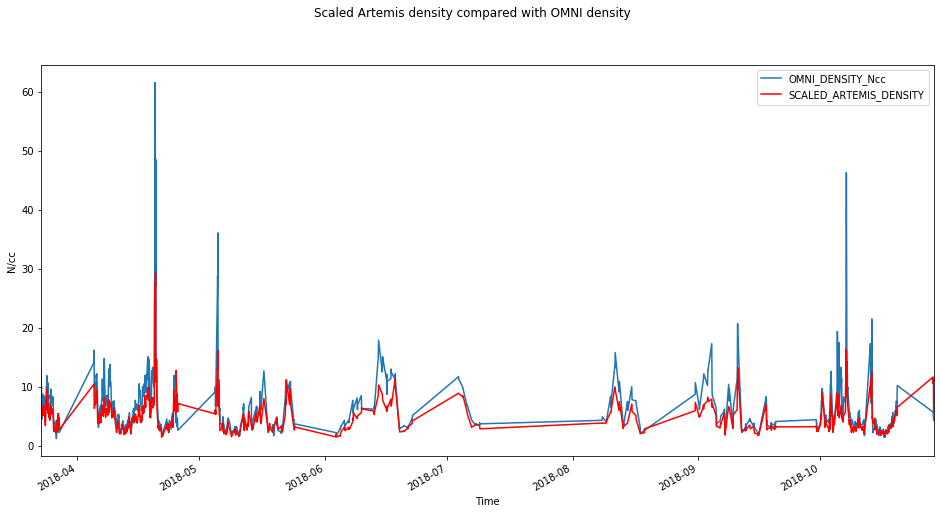

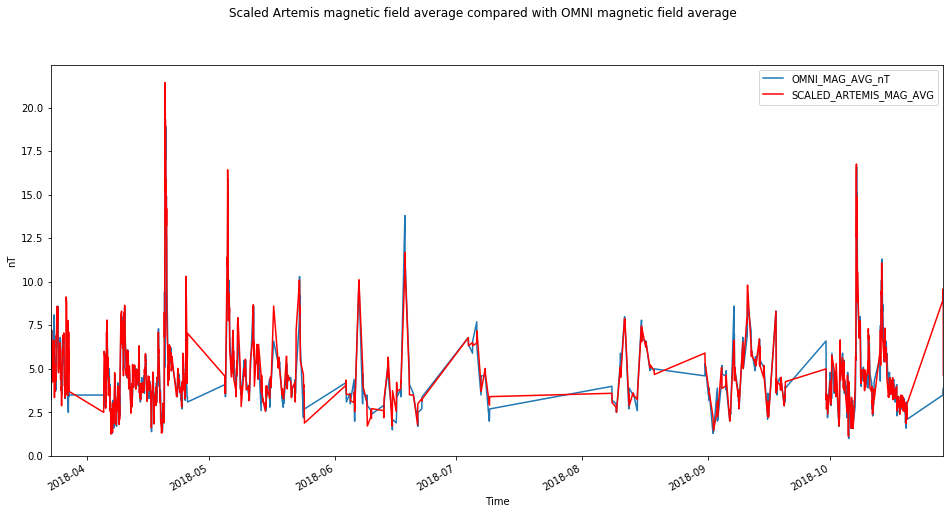

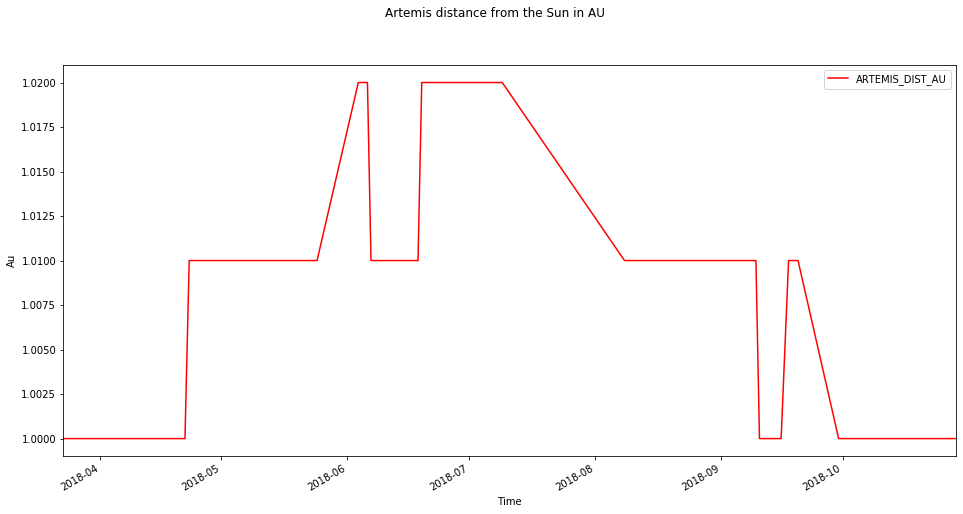

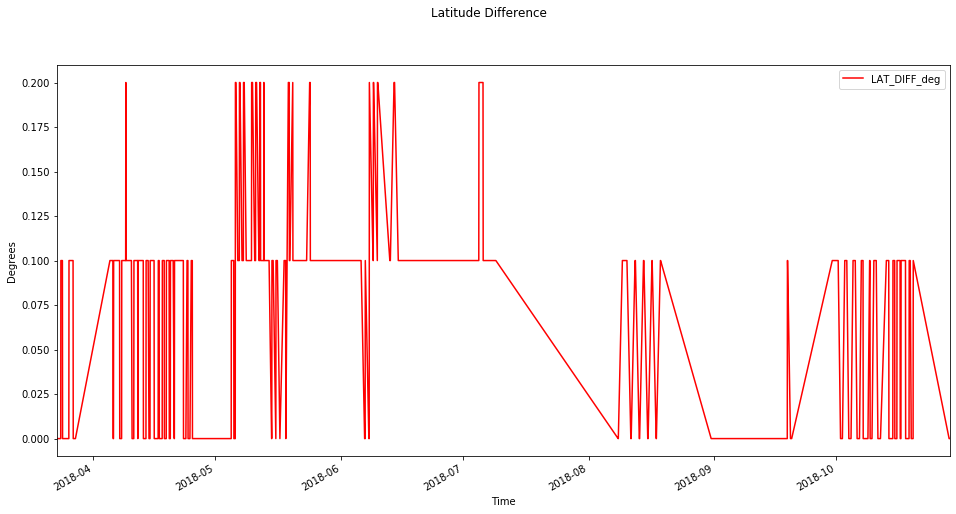

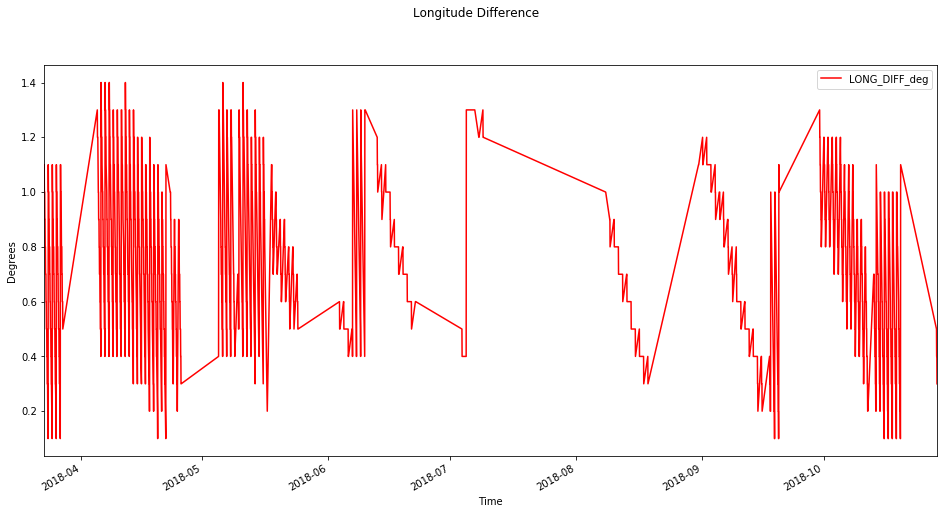

In [3]:
posFrame = pd.read_csv('csv files/POS4Artemis1Year.csv')
windFrame = pd.read_csv('csv files/SW4Artemis1Year.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_MAG_AVG_nt != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_DENSITY_Ncc != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_SPEED_kms != -1.0E+31]

mergedFrame = mergedFrame[mergedFrame['GSE_X_RE'] >= -35]
mergedFrame = mergedFrame[mergedFrame['SSE_X_RM'] >= 0]
mergedFrame = mergedFrame[mergedFrame['ARTEMIS_DIST_AU'] >= 1]
mergedFrame = mergedFrame.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis1Year.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['OMNI_MAG_AVG_nT'] != -1.0E+31]
df2 = df2[df2['OMNI_SPEED_kms'] != -1.0E+31]
df2 = df2[df2['OMNI_DENSITY_Ncc'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

mergedFrame = mergedFrame.drop(['GSE_X_RE', 'GSE_Y_RE', 'GSE_Z_RE', 'SSE_X_RM', 'SSE_Y_RM', 'SSE_Z_RM'], axis=1)
mergedFrame['new_time'] = mergedFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
mergedFrame['Time_offset_hours'] = 1

mF = pd.merge(df2, mergedFrame, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

mF.rename(columns = {'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ':'OMNI Time',
                     'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ':'Time'}, inplace = True)

mF['LAT_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LAT_deg - row.ARTEMIS_LAT_DEG), axis = 1)
mF['LONG_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LONG_deg - row.ARTEMIS_LONG_DEG), axis = 1) 
mF['SCALED_ARTEMIS_DENSITY'] = mF.apply(lambda row: row.ARTEMIS_DENSITY_Ncc * row.ARTEMIS_DIST_AU * row.ARTEMIS_DIST_AU, axis = 1)
mF['SCALED_ARTEMIS_MAG_AVG'] = mF.apply(lambda row: row.ARTEMIS_MAG_AVG_nt * row.ARTEMIS_DIST_AU, axis = 1)

fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_SPEED_kms', ax=ax)
mF.plot(kind='line', x='Time', y='ARTEMIS_SPEED_kms', color='red', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_DENSITY_Ncc', ax=ay)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_DENSITY', color='red', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_MAG_AVG_nT', ax=az)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_MAG_AVG', color='red', ax=az)
plt.ylabel("nT")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='Time', y='ARTEMIS_DIST_AU', color='red', ax=az)
plt.ylabel("Au")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Latitude Difference")
az = plt.gca()
mF.plot(kind='line', x='Time', y='LAT_DIFF_deg', color='red', ax=az)
plt.ylabel("Degrees")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Longitude Difference")
az = plt.gca()
mF.plot(kind='line', x='Time', y='LONG_DIFF_deg', color='red', ax=az)
plt.ylabel("Degrees")

plt.show()

We were also asked to provide the difference between the OMNI and Artemis values plotted against the longitude values. Essentially this was to see if we saw more error in the time periods where Artemis and OMNI didn't line up.

C:\Users\Ian\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


Text(0, 0.5, 'nT')

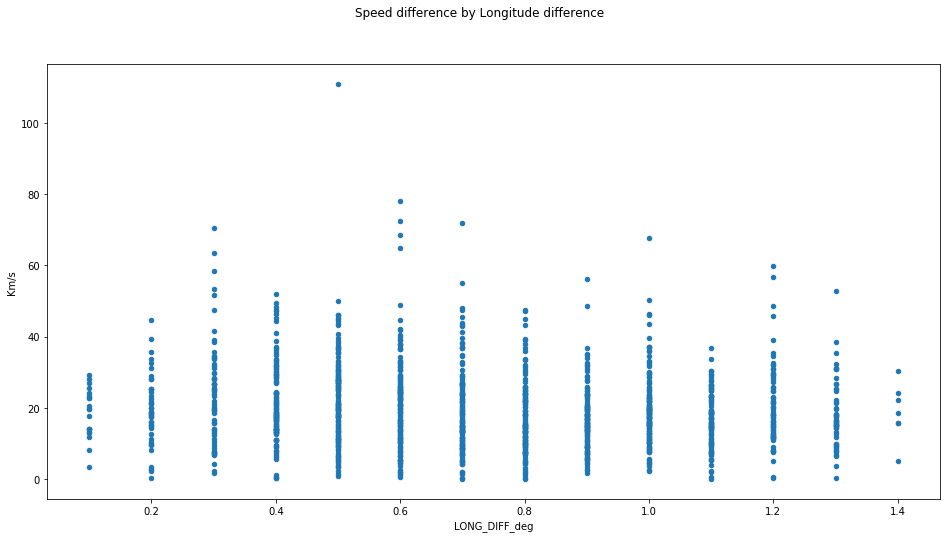

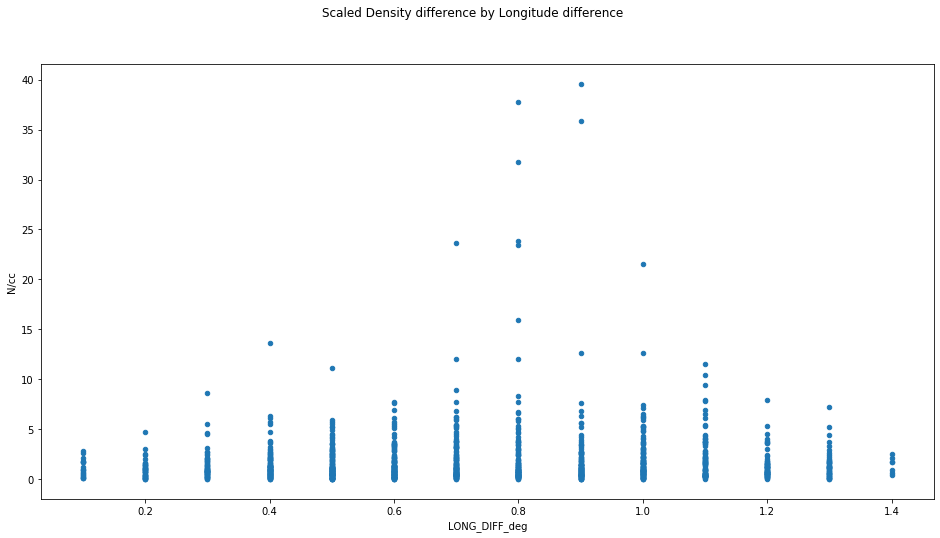

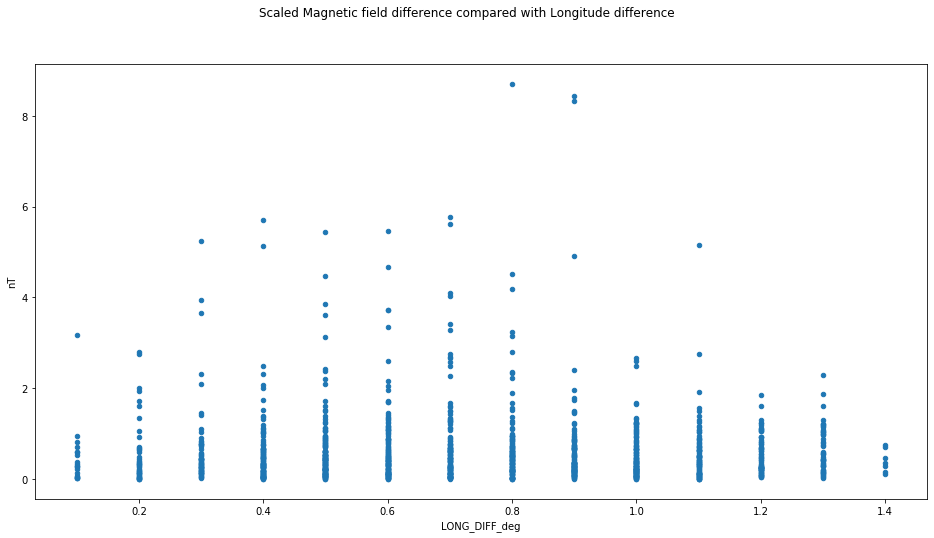

In [4]:
mF['Speed_DIFF_Kms'] = mF.apply(lambda row: abs(row.OMNI_SPEED_kms - row.ARTEMIS_SPEED_kms), axis = 1)
mF['Density_DIFF_Ncc'] = mF.apply(lambda row: abs(row.OMNI_DENSITY_Ncc - row.SCALED_ARTEMIS_DENSITY), axis = 1)
mF['Mag_DIFF_nT'] = mF.apply(lambda row: abs(row.OMNI_MAG_AVG_nT - row.SCALED_ARTEMIS_MAG_AVG), axis = 1)

fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Speed difference by Longitude difference")
ax = plt.gca()
mF.plot(kind='scatter', x='LONG_DIFF_deg', y='Speed_DIFF_Kms', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Density difference by Longitude difference")
ay = plt.gca()
mF.plot(kind='scatter', x='LONG_DIFF_deg', y='Density_DIFF_Ncc', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Magnetic field difference compared with Longitude difference")
az = plt.gca()
mF.plot(kind='scatter', x='LONG_DIFF_deg', y='Mag_DIFF_nT', ax=az)
plt.ylabel("nT")

Text(0, 0.5, 'nT')

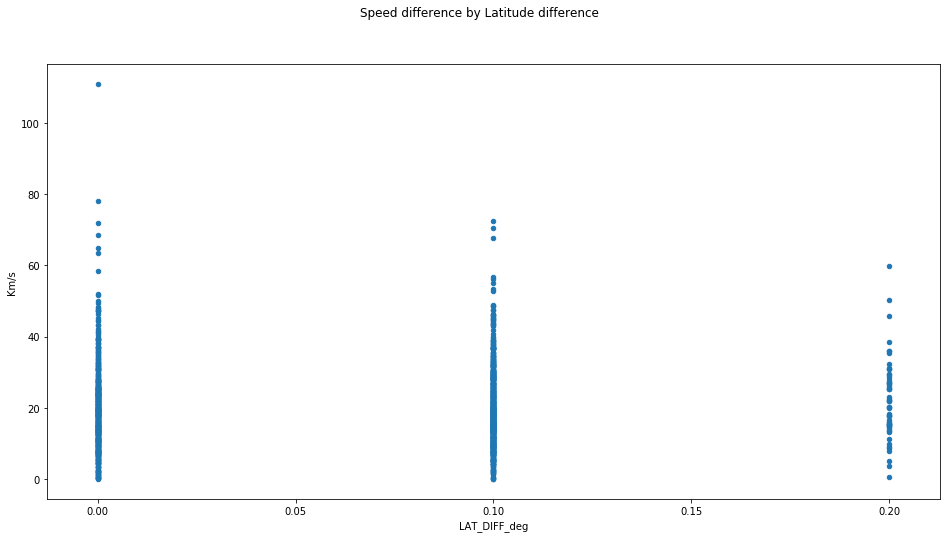

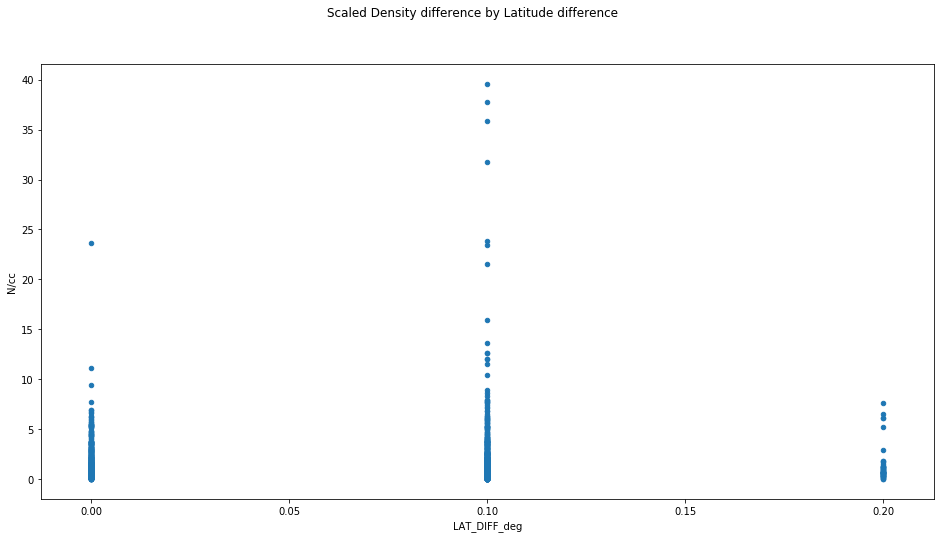

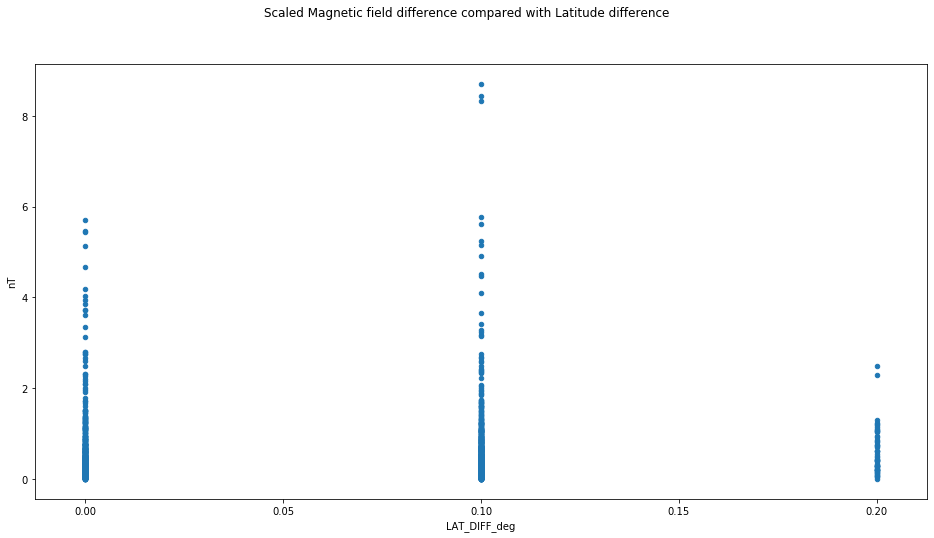

In [5]:
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Speed difference by Latitude difference")
ax = plt.gca()
mF.plot(kind='scatter', x='LAT_DIFF_deg', y='Speed_DIFF_Kms', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Density difference by Latitude difference")
ay = plt.gca()
mF.plot(kind='scatter', x='LAT_DIFF_deg', y='Density_DIFF_Ncc', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Magnetic field difference compared with Latitude difference")
az = plt.gca()
mF.plot(kind='scatter', x='LAT_DIFF_deg', y='Mag_DIFF_nT', ax=az)
plt.ylabel("nT")

Text(0, 0.5, 'nT')

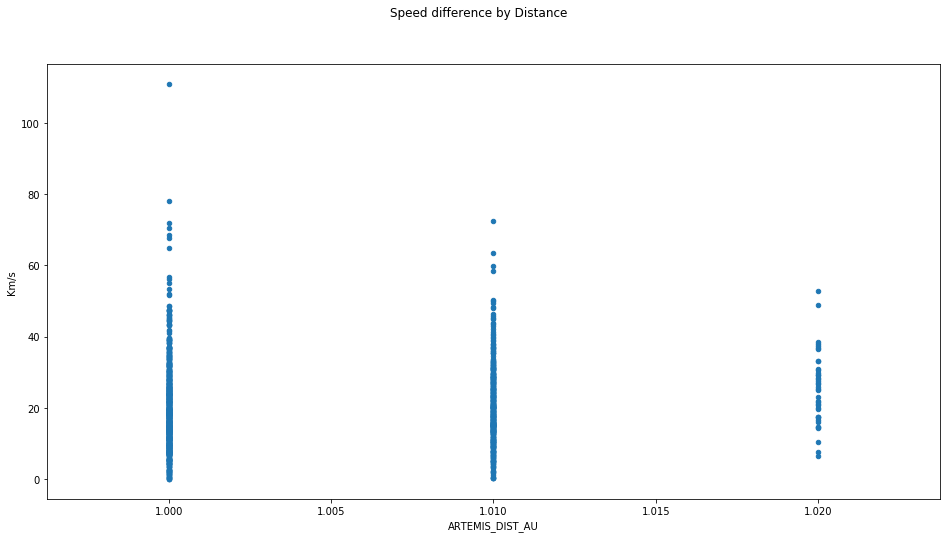

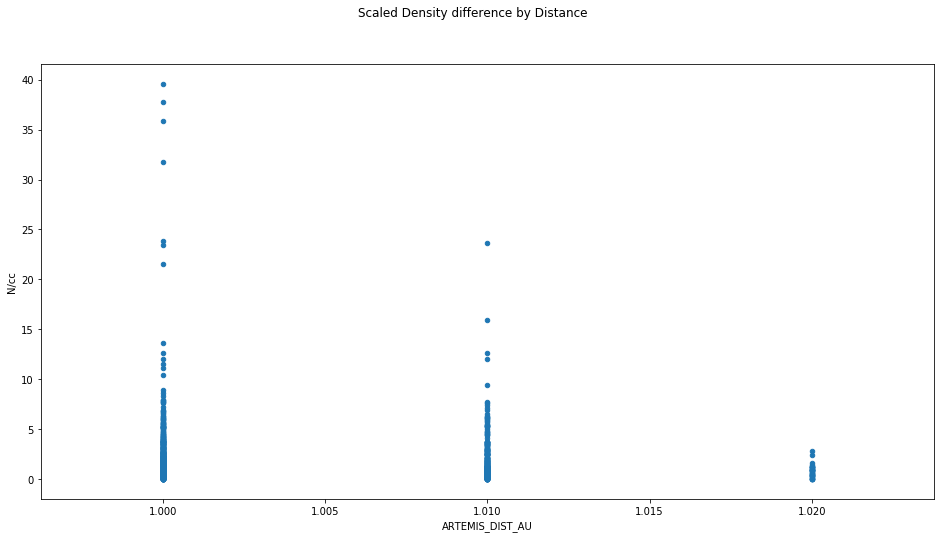

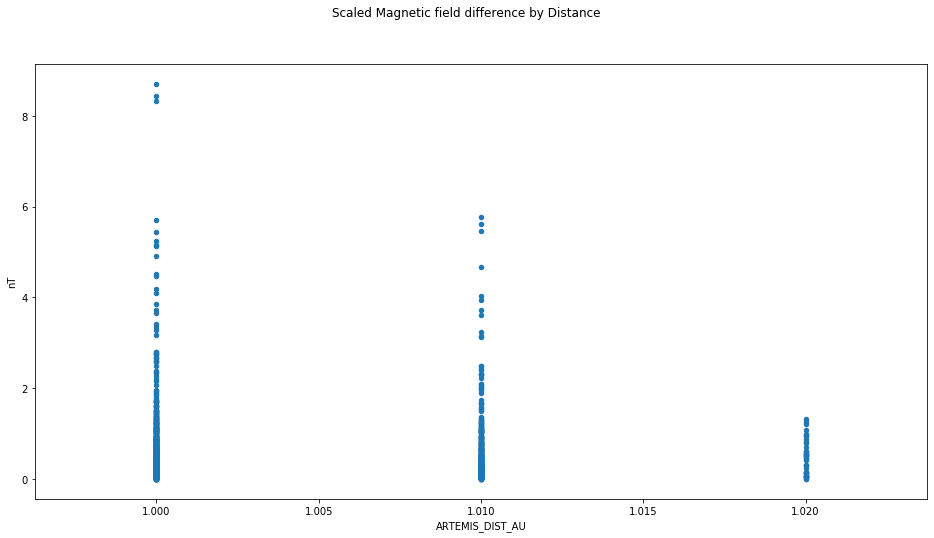

In [6]:
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Speed difference by Distance")
ax = plt.gca()
mF.plot(kind='scatter', x='ARTEMIS_DIST_AU', y='Speed_DIFF_Kms', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Density difference by Distance")
ay = plt.gca()
mF.plot(kind='scatter', x='ARTEMIS_DIST_AU', y='Density_DIFF_Ncc', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Magnetic field difference by Distance")
az = plt.gca()
mF.plot(kind='scatter', x='ARTEMIS_DIST_AU', y='Mag_DIFF_nT', ax=az)
plt.ylabel("nT")

We did the same process on another 7-8 month's worth of data, and achieved a similar result. Essentially the approach for the Artemis mission allows for a large amount of data to be collected at once, however it doesn't provide a lot of predictive power due to the fact that Artemis' position is so close to the OMNI satelites.

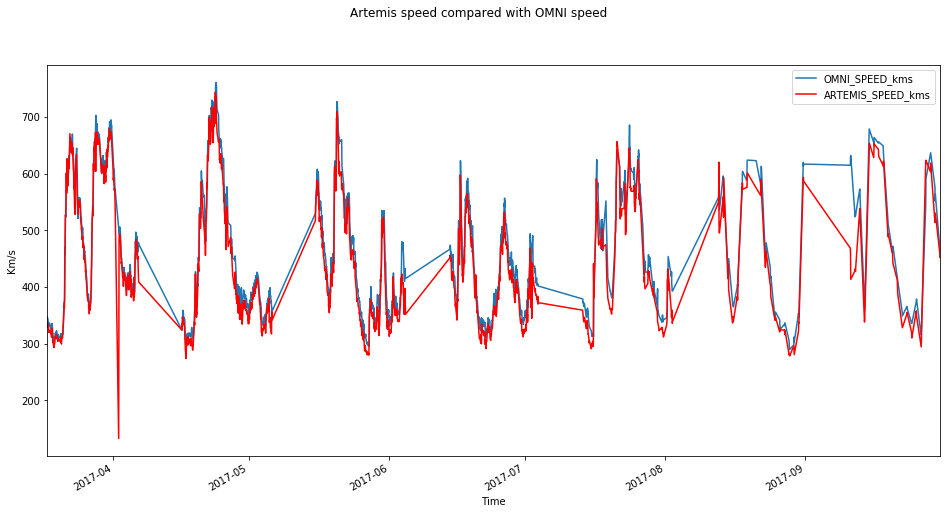

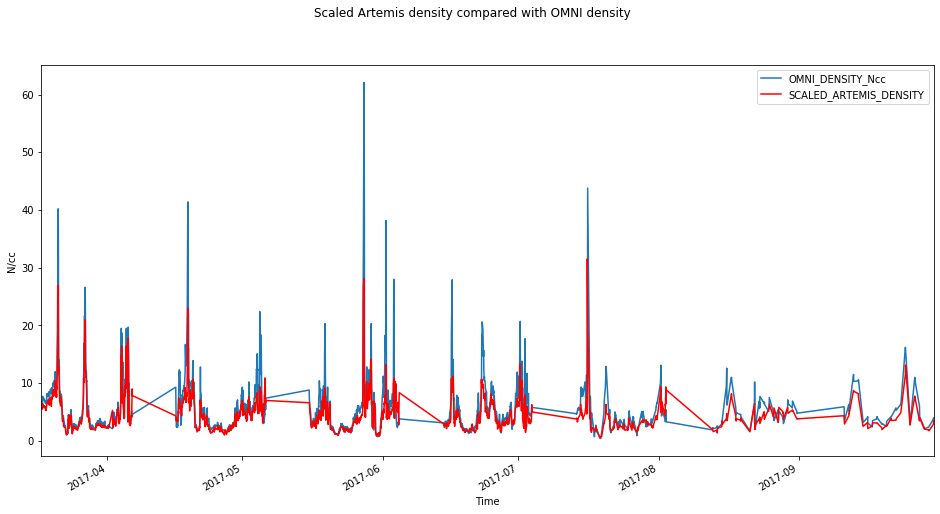

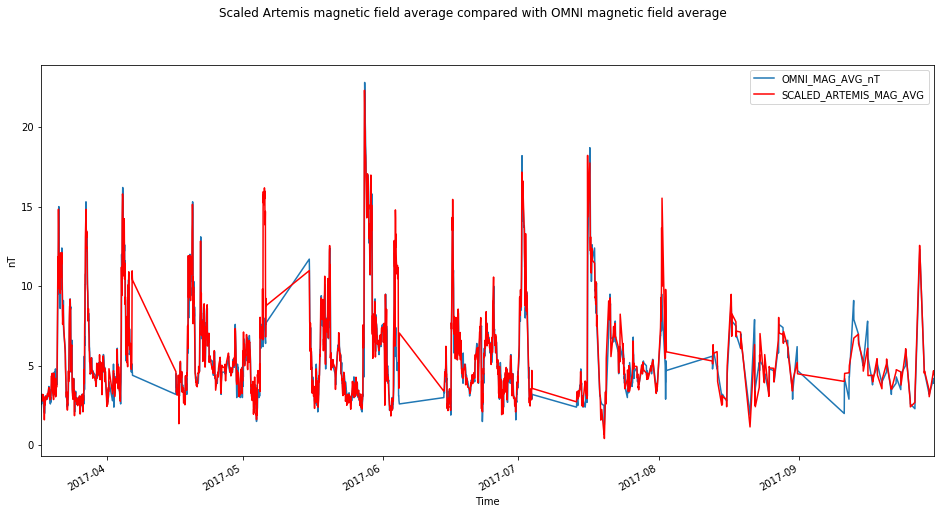

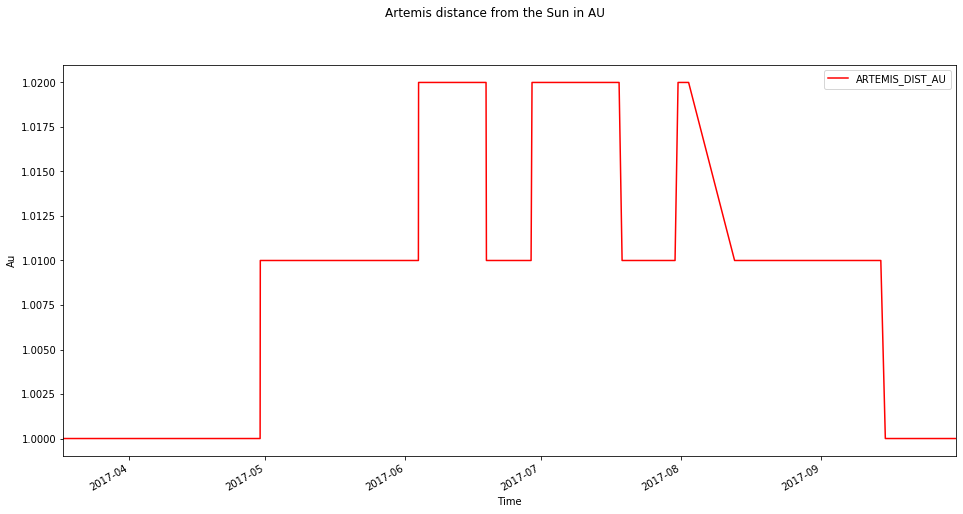

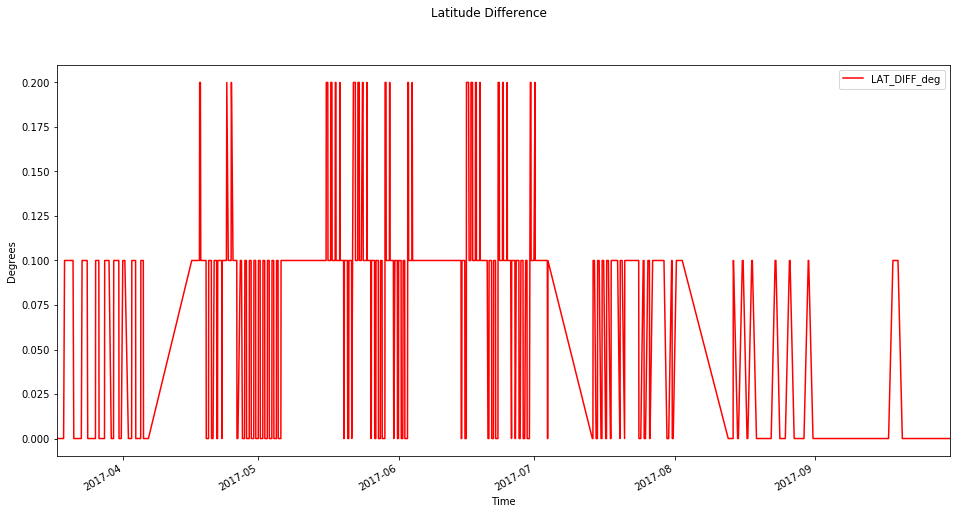

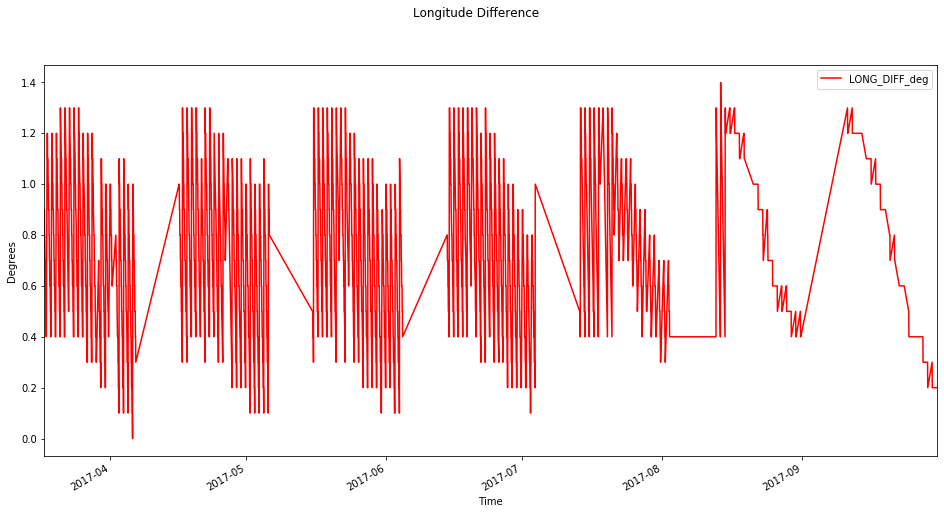

In [7]:
posFrame = pd.read_csv('csv files/POS4Artemis1Year2.csv')
windFrame = pd.read_csv('csv files/SW4Artemis1Year2.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_MAG_AVG_nt != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_DENSITY_Ncc != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_SPEED_kms != -1.0E+31]

mergedFrame = mergedFrame[mergedFrame['GSE_X_RE'] >= -35]
mergedFrame = mergedFrame[mergedFrame['SSE_X_RM'] >= 0]
mergedFrame = mergedFrame[mergedFrame['ARTEMIS_DIST_AU'] >= 1]
mergedFrame = mergedFrame.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis1Year2.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['OMNI_MAG_AVG_nT'] != -1.0E+31]
df2 = df2[df2['OMNI_SPEED_kms'] != -1.0E+31]
df2 = df2[df2['OMNI_DENSITY_Ncc'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

mergedFrame = mergedFrame.drop(['GSE_X_RE', 'GSE_Y_RE', 'GSE_Z_RE', 'SSE_X_RM', 'SSE_Y_RM', 'SSE_Z_RM'], axis=1)
mergedFrame['new_time'] = mergedFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
mergedFrame['Time_offset_hours'] = 1

mF = pd.merge(df2, mergedFrame, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

mF.rename(columns = {'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ':'OMNI Time',
                     'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ':'Time'}, inplace = True)

mF['LAT_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LAT_deg - row.ARTEMIS_LAT_DEG), axis = 1)
mF['LONG_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LONG_deg - row.ARTEMIS_LONG_DEG), axis = 1) 
mF['SCALED_ARTEMIS_DENSITY'] = mF.apply(lambda row: row.ARTEMIS_DENSITY_Ncc * row.ARTEMIS_DIST_AU * row.ARTEMIS_DIST_AU, axis = 1)
mF['SCALED_ARTEMIS_MAG_AVG'] = mF.apply(lambda row: row.ARTEMIS_MAG_AVG_nt * row.ARTEMIS_DIST_AU, axis = 1)

fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_SPEED_kms', ax=ax)
mF.plot(kind='line', x='Time', y='ARTEMIS_SPEED_kms', color='red', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_DENSITY_Ncc', ax=ay)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_DENSITY', color='red', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_MAG_AVG_nT', ax=az)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_MAG_AVG', color='red', ax=az)
plt.ylabel("nT")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='Time', y='ARTEMIS_DIST_AU', color='red', ax=az)
plt.ylabel("Au")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Latitude Difference")
az = plt.gca()
mF.plot(kind='line', x='Time', y='LAT_DIFF_deg', color='red', ax=az)
plt.ylabel("Degrees")

fig4 = plt.figure(figsize=(16, 8))
fig4.suptitle("Longitude Difference")
az = plt.gca()
mF.plot(kind='line', x='Time', y='LONG_DIFF_deg', color='red', ax=az)
plt.ylabel("Degrees")

plt.show()

Text(0, 0.5, 'nT')

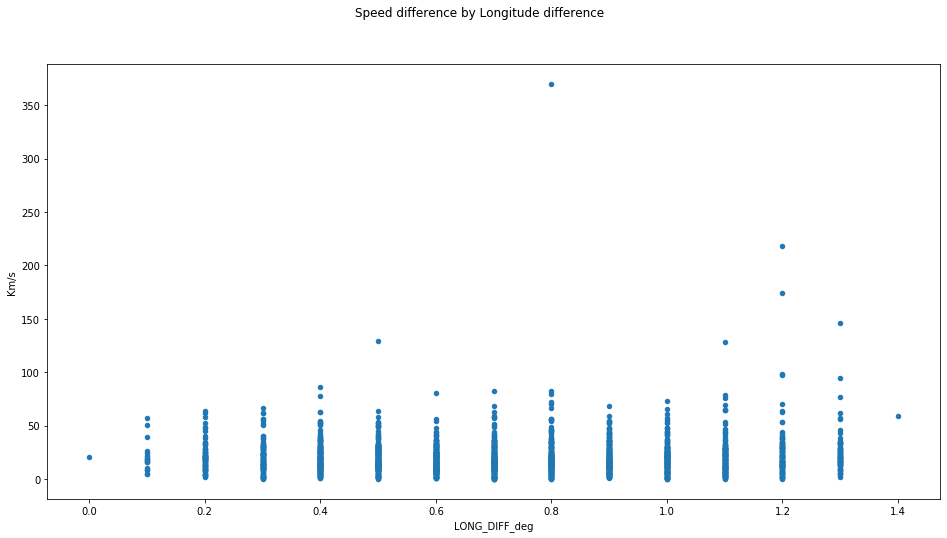

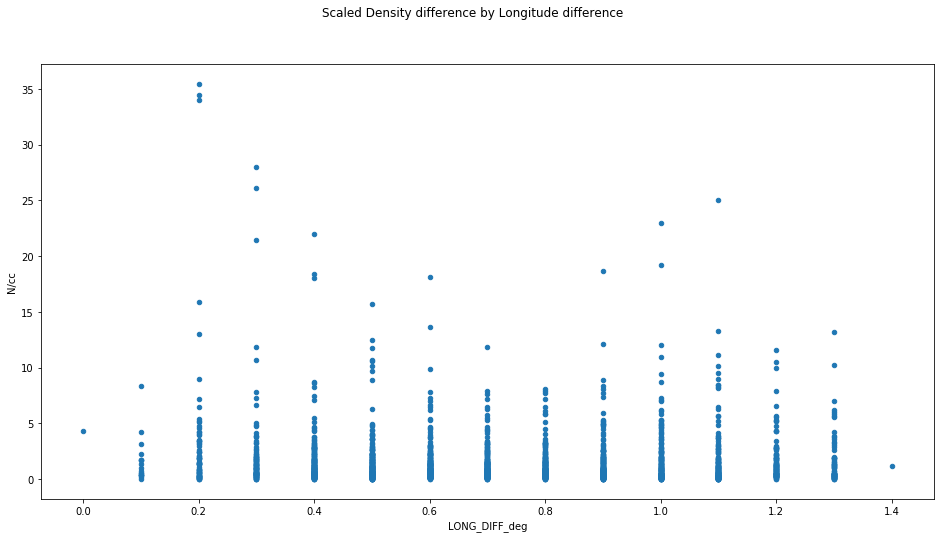

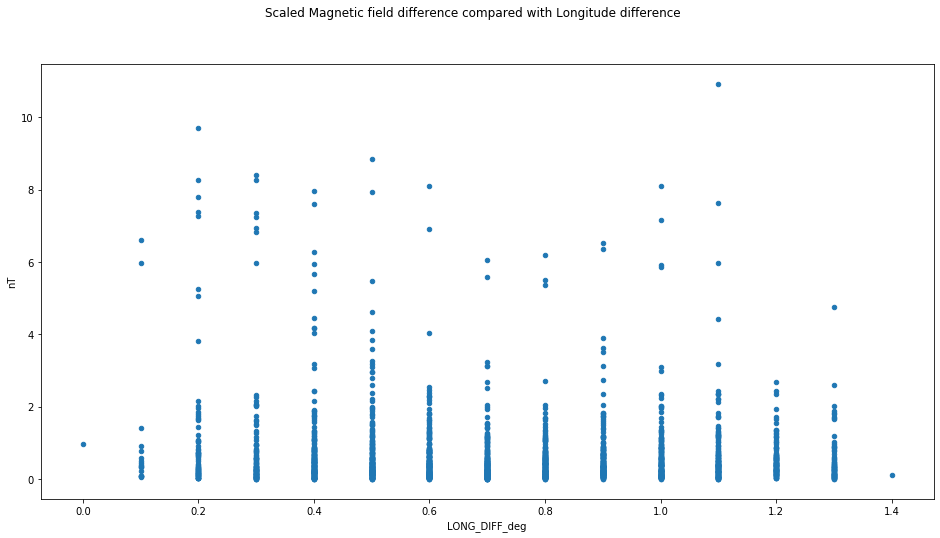

In [8]:
mF['Speed_DIFF_Kms'] = mF.apply(lambda row: abs(row.OMNI_SPEED_kms - row.ARTEMIS_SPEED_kms), axis = 1)
mF['Density_DIFF_Ncc'] = mF.apply(lambda row: abs(row.OMNI_DENSITY_Ncc - row.SCALED_ARTEMIS_DENSITY), axis = 1)
mF['Mag_DIFF_nT'] = mF.apply(lambda row: abs(row.OMNI_MAG_AVG_nT - row.SCALED_ARTEMIS_MAG_AVG), axis = 1)

fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Speed difference by Longitude difference")
ax = plt.gca()
mF.plot(kind='scatter', x='LONG_DIFF_deg', y='Speed_DIFF_Kms', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Density difference by Longitude difference")
ay = plt.gca()
mF.plot(kind='scatter', x='LONG_DIFF_deg', y='Density_DIFF_Ncc', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Magnetic field difference compared with Longitude difference")
az = plt.gca()
mF.plot(kind='scatter', x='LONG_DIFF_deg', y='Mag_DIFF_nT', ax=az)
plt.ylabel("nT")

Text(0, 0.5, 'nT')

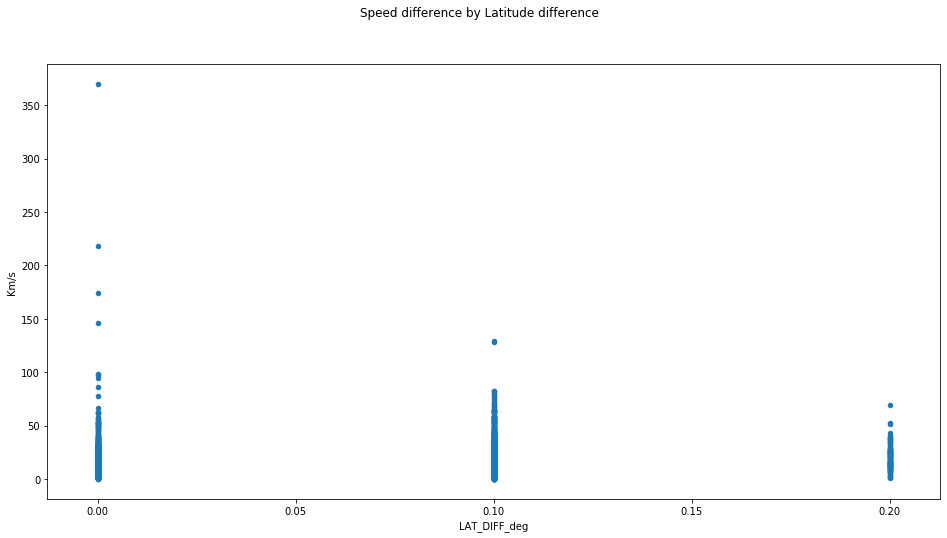

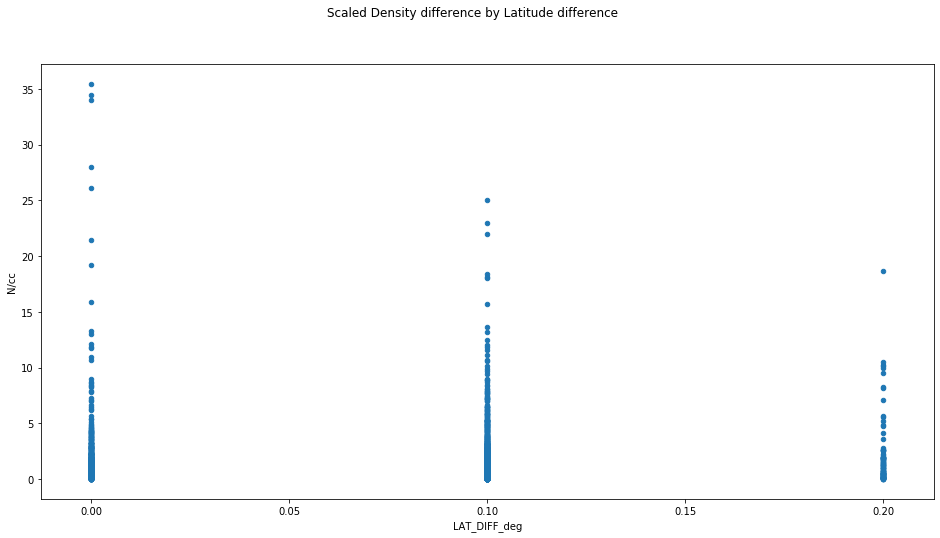

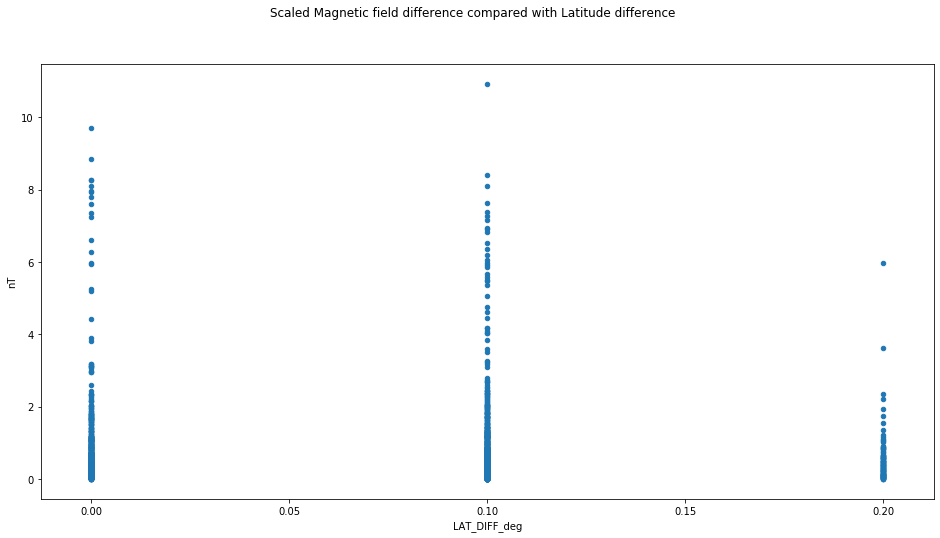

In [9]:
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Speed difference by Latitude difference")
ax = plt.gca()
mF.plot(kind='scatter', x='LAT_DIFF_deg', y='Speed_DIFF_Kms', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Density difference by Latitude difference")
ay = plt.gca()
mF.plot(kind='scatter', x='LAT_DIFF_deg', y='Density_DIFF_Ncc', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Magnetic field difference compared with Latitude difference")
az = plt.gca()
mF.plot(kind='scatter', x='LAT_DIFF_deg', y='Mag_DIFF_nT', ax=az)
plt.ylabel("nT")

Text(0, 0.5, 'nT')

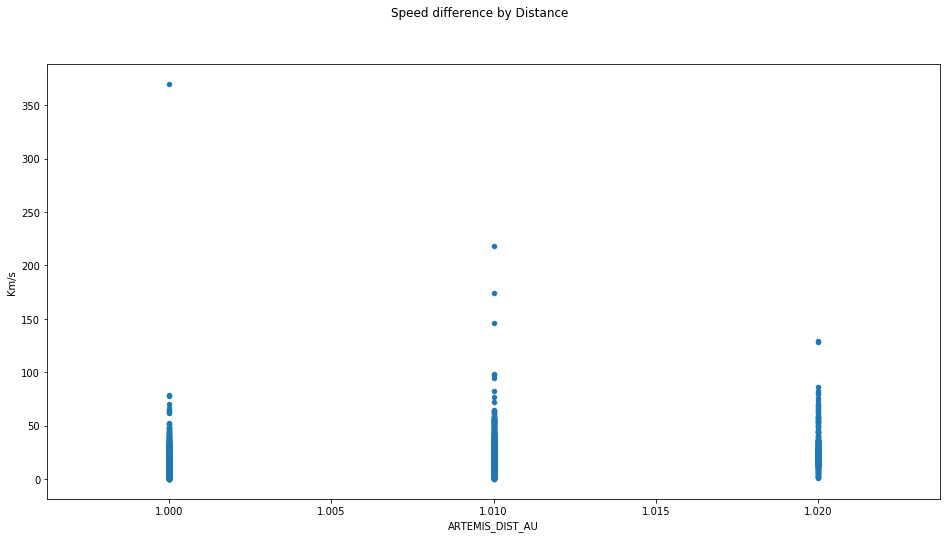

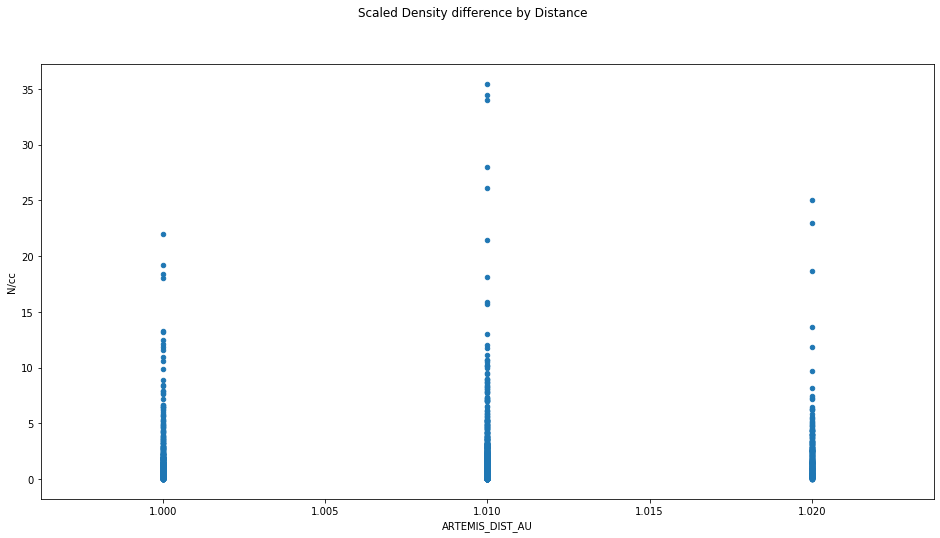

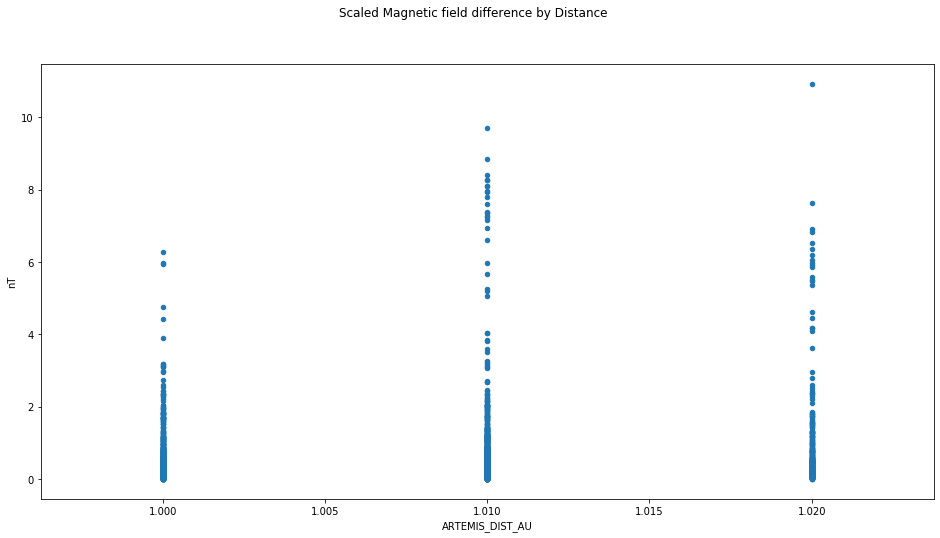

In [10]:
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Speed difference by Distance")
ax = plt.gca()
mF.plot(kind='scatter', x='ARTEMIS_DIST_AU', y='Speed_DIFF_Kms', ax=ax)
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Density difference by Distance")
ay = plt.gca()
mF.plot(kind='scatter', x='ARTEMIS_DIST_AU', y='Density_DIFF_Ncc', ax=ay)
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Magnetic field difference by Distance")
az = plt.gca()
mF.plot(kind='scatter', x='ARTEMIS_DIST_AU', y='Mag_DIFF_nT', ax=az)
plt.ylabel("nT")

We were also asked to show some of the arrival times between the OMNI and Artemis data to show how accurate the time-shift is. Here are some periods where the time-shift is working well on the Artemis data from the second year of data.

Text(0, 0.5, 'nT')

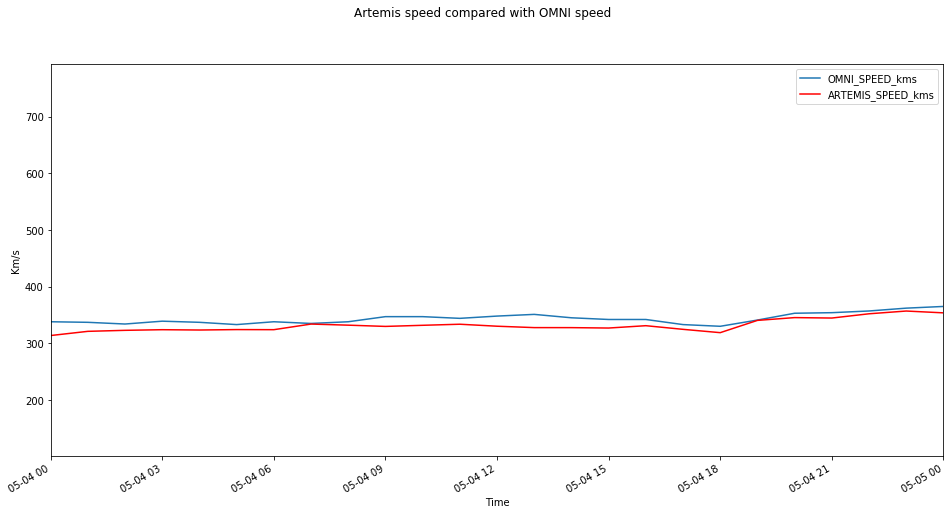

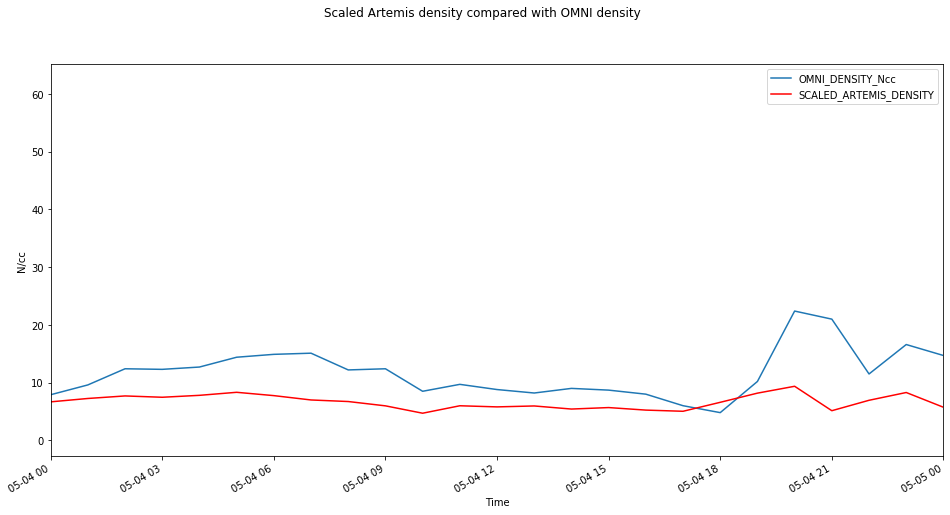

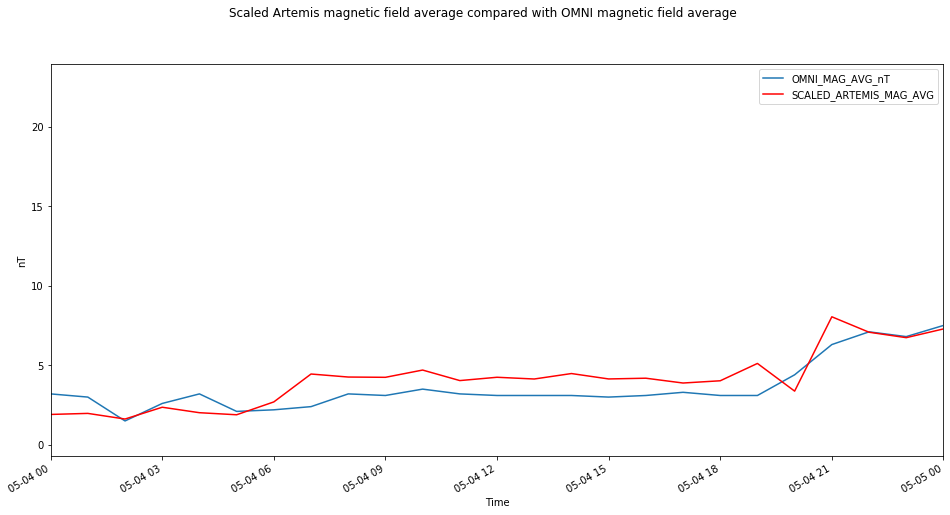

In [20]:
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_SPEED_kms', ax=ax)
mF.plot(kind='line', x='Time', y='ARTEMIS_SPEED_kms', color='red', ax=ax)
ax.set_xlim([datetime.date(2017, 5, 4), datetime.date(2017, 5, 5)])
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_DENSITY_Ncc', ax=ay)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_DENSITY', color='red', ax=ay)
ay.set_xlim([datetime.date(2017, 5, 4), datetime.date(2017, 5, 5)])
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_MAG_AVG_nT', ax=az)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_MAG_AVG', color='red', ax=az)
az.set_xlim([datetime.date(2017, 5, 4), datetime.date(2017, 5, 5)])
plt.ylabel("nT")

Here is a place where the time-shift is not performing as well.

Text(0, 0.5, 'nT')

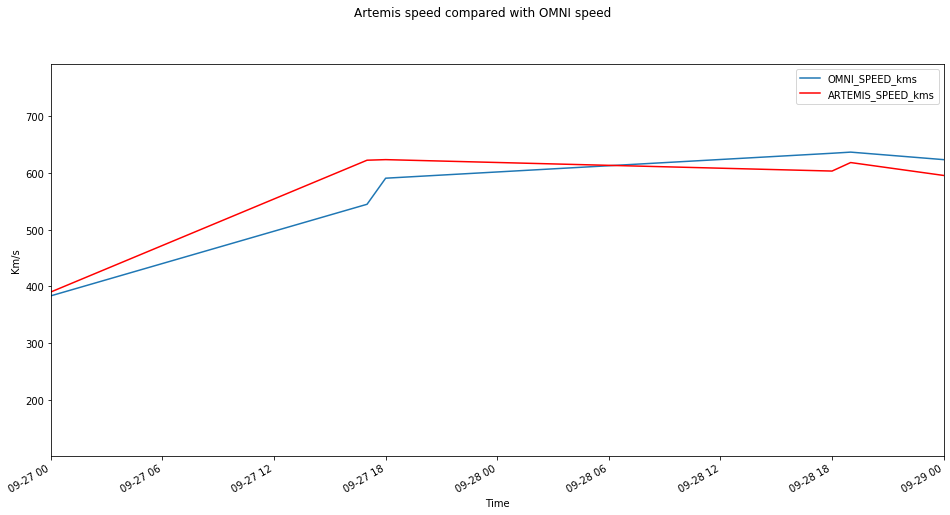

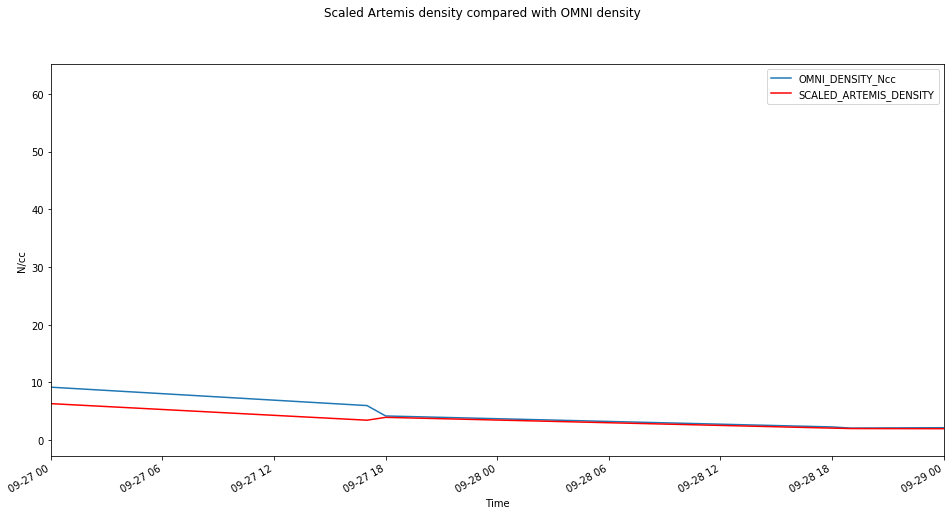

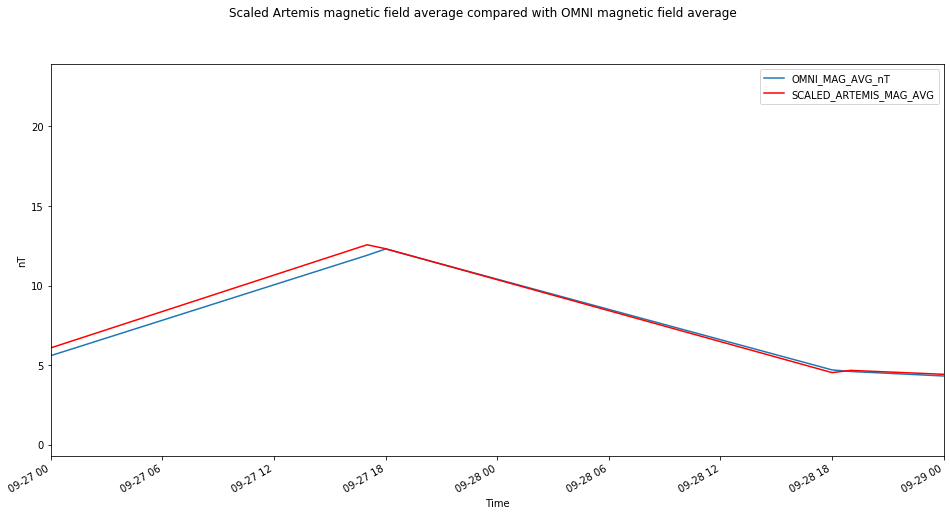

In [22]:
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_SPEED_kms', ax=ax)
mF.plot(kind='line', x='Time', y='ARTEMIS_SPEED_kms', color='red', ax=ax)
ax.set_xlim([datetime.date(2017, 9, 27), datetime.date(2017, 9, 29)])
plt.ylabel("Km/s")

fig2 = plt.figure(figsize=(16, 8))
fig2.suptitle("Scaled Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_DENSITY_Ncc', ax=ay)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_DENSITY', color='red', ax=ay)
ay.set_xlim([datetime.date(2017, 9, 27), datetime.date(2017, 9, 29)])
plt.ylabel("N/cc")

fig3 = plt.figure(figsize=(16, 8))
fig3.suptitle("Scaled Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='Time', y='OMNI_MAG_AVG_nT', ax=az)
mF.plot(kind='line', x='Time', y='SCALED_ARTEMIS_MAG_AVG', color='red', ax=az)
az.set_xlim([datetime.date(2017, 9, 27), datetime.date(2017, 9, 29)])
plt.ylabel("nT")

From these plots, we can conclude that when the time-shift is performing well, the data follows the peaks of the data fairly closely without much of a difference in the arrival time, when it is not performing well, the data can be off by an hour or so in terms of arrival time.

To conclude, using approach that we used with the Artemis data seems to be successful. In part, this is due to the fact that the position of Artemis is never very different from what the positions of the OMNI satelites is. The Artemis data is also a good proof of concept for using other missions that orbit planets because these missions will have a more consistent distance from the Sun, and could be time-shifted fairly easily given that their Longitude/Latitude does not vary much from OMNI, and that they are not being affected by their proximity to the planet they orbit.